# **StarGAN - CelebA**

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [7]:
workers = 2
batch_size = 64
nz = 100
nc = 3
image_size = 128

epochs = 100
lr = 0.0001
beta1, beta2 = 0.5, 0.999
lamb = 10
n_critic = 5
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [3]:
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Already kaggle.json exsits.")
else:
    !mkdir -p ~/.kaggle
    !cp ./kaggle.json ~/.kaggle/ 
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('./img_align_celeba'):
    print("Already unzip.")
else:
    !unzip -q celeba-dataset.zip
    print("Unzip Complete!")

cp: cannot stat './kaggle.json': No such file or directory
 99%|██████████████████████████████████████▌| 1.32G/1.33G [00:13<00:00, 175MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:13<00:00, 107MB/s]
Unzip Complete!


In [8]:
dataset = datasets.ImageFolder(root='./img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [5]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return img

In [24]:
import csv

# Attractive, Blond_Hair, Male, Young
attr_idx = [3, 10, 21, 40]
attr_dict = {}

with open('list_attr_celeba.csv','r') as f:
    rdr = csv.reader(f)
    for line in rdr:
        temp_list = []
        for idx in attr_idx:
            if line[idx] == '1':
                temp_list.append(1)
            elif line[idx] == '-1':
                temp_list.append(0)
        attr_dict[line[0]] = temp_list

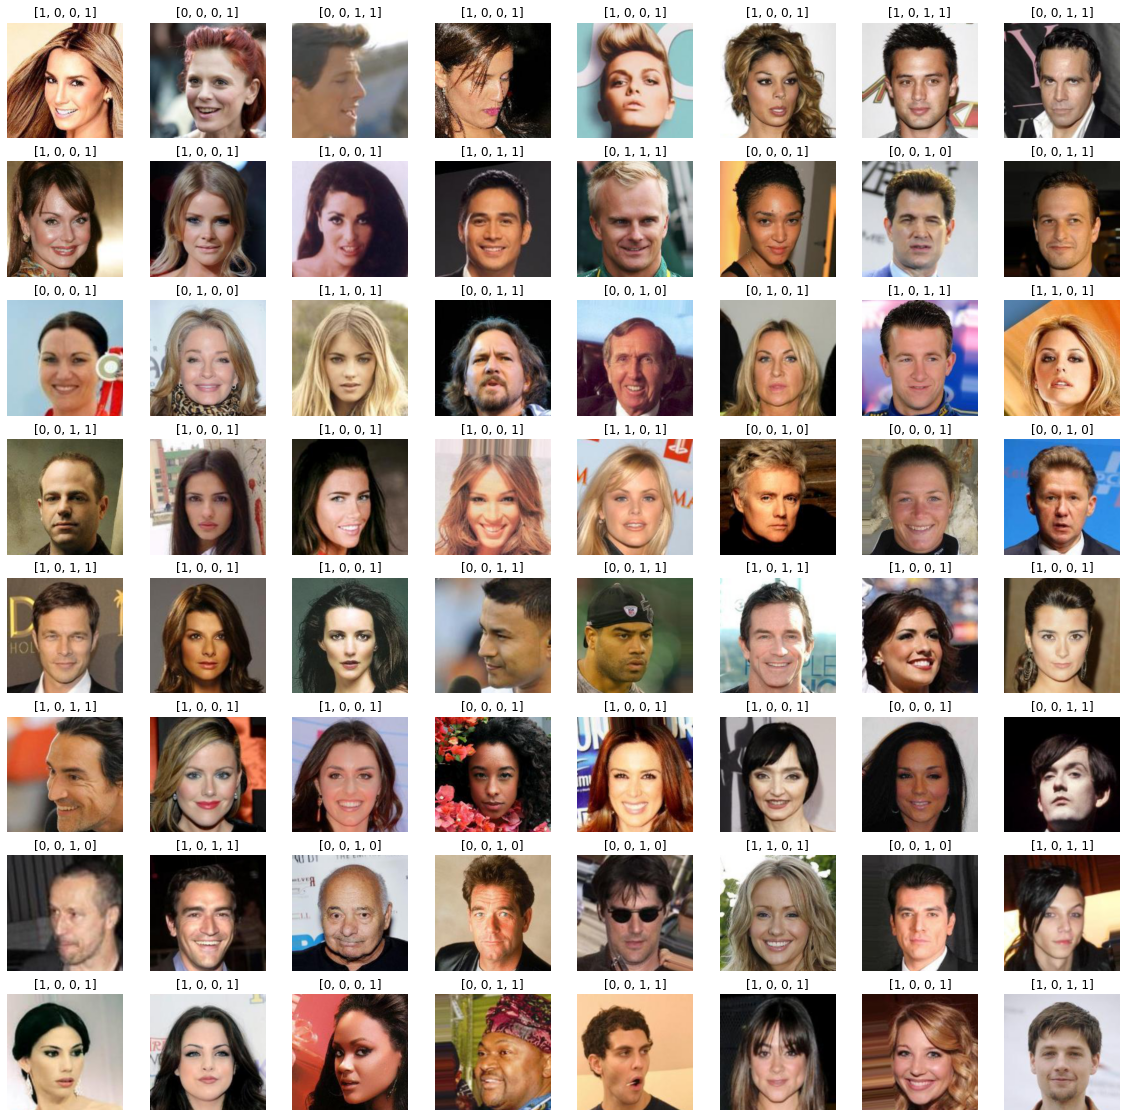

In [28]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
    img, idx = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax.set_title(attr_dict['%06d.jpg' % (k+1)])

plt.show()

# Generator

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Res_Block(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Res_Block, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True)
        )

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    def __init__(self, ngf=64, nc=4, n_res_block=6):
        super(Generator, self).__init__()
        self.n_res_block = n_res_block
        self.enc = nn.Sequential(
            # 128x128x7
            nn.Conv2d(3+nc, ngf, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*4, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            # 32x32x256
        )

        self.dec = nn.Sequential(
            # 32x32x256
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, 3, 7, 1, 3, bias=False),
            nn.Tanh()
            # 128x128x3
        )

        self.res = []
        for _ in range(n_res_block):
            block = Res_Block(ngf*4).to(device)
            block.apply(weights_init)
            self.res.append(block)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        
        x = self.enc(x)
        
        for i in range(self.n_res_block):
            x = self.res[i](x)
            
        return self.dec(x)
  
    def saveResBlocks(self, path):
        for idx, block in enumerate(self.res):
            torch.save(block.state_dict(), path.replace('.pt', F'_{idx}.pt'))

    def loadResBlocks(self, path):
        for idx in range(self.n_res_block):
            self.res[idx].load_state_dict(torch.load(path.replace('.pt', F'_{idx}.pt')))

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=4):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.main = nn.Sequential(
            # 128x128x3
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 64x64x64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 32x32x128
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 16x16x256
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 8x8x512
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 4x4x1024
            nn.Conv2d(ndf*16, ndf*32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 2x2x2048
        )
        self.conv1 = nn.Conv2d(ndf*32, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf*32, nc, kernel_size=2, bias=False)

    def forward(self, x):
        x = self.main(x)        
        return self.conv1(x), self.conv2(x).view(-1, self.nc)